<a href="https://colab.research.google.com/github/bhadreshpsavani/100daysofNLP/blob/main/notebooks/Distilbert_Model_Interpretability_With_Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretability with Captum

In NLP We build model with great performance but Its important to know how model is making prediction. What kind of text is focused and observed by neuron/layer/model.

If its pytorch model than Captum is decent library.

In [1]:
# install dependency
!pip install -q transformers captum

     |████████████████████████████████| 2.6 MB 12.1 MB/s 
     |████████████████████████████████| 1.4 MB 36.8 MB/s 
     |████████████████████████████████| 3.3 MB 43.5 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 636 kB 50.4 MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# load model
model_path = "bhadresh-savani/distilbert-base-uncased-emotion"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

Downloading:   0%|          | 0.00/783 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
text = "It is important to us to include, empower and support humans of all kinds."
inputs = tokenizer(text, return_tensors='pt')
all_tokens = tokenizer.tokenize(text)
inputs, all_tokens

({'input_ids': tensor([[  101,  2009,  2003,  2590,  2000,  2149,  2000,  2421,  1010,  7861,
          11452,  1998,  2490,  4286,  1997,  2035,  7957,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])},
 ['it',
  'is',
  'important',
  'to',
  'us',
  'to',
  'include',
  ',',
  'em',
  '##power',
  'and',
  'support',
  'humans',
  'of',
  'all',
  'kinds',
  '.'])

In [34]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [62]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_distilbert_embeddings(input_ids, ref_input_ids, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.distilbert.embeddings(input_ids)
    ref_input_embeddings = model.distilbert.embeddings(ref_input_ids)
    return input_embeddings, ref_input_embeddings

In [47]:
input_ids, ref_input_ids = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [55]:
def predict(inputs, position_ids=None):
  inputs = inputs.to(device)
  output = model(inputs)
  return output['logits']

In [57]:
scores = predict(inputs=input_ids)
scores

tensor([[-1.5874,  6.0608, -0.4590, -1.1665, -2.2359, -2.7324]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## 1. Analyse Distilbert Embedding Layers:

In [22]:
lig = LayerIntegratedGradients(predict, model.distilbert.embeddings)

attributions, delta = lig.attribute(inputs=input_ids,
                                  target=1,
                                  return_convergence_delta=True)

In [23]:
# A helper function to summarize attributions for each word token in the sequence.
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [24]:
attributions_sum = summarize_attributions(attributions)

In [25]:
position_vis = viz.VisualizationDataRecord(
                        attributions_sum,
                        torch.max(torch.softmax(scores[0], dim=0)),
                        torch.argmax(scores),
                        torch.argmax(scores),
                        str(1),
                        attributions_sum.sum(),       
                        all_tokens,
                        delta)

print('\033[1m', 'Visualizations', '\033[0m')
viz.visualize_text([position_vis])

 Visualizations 


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),1,2.46,"it is important to us to include , em ##power and support humans of all kinds ."


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,1 (1.00),1,2.46,"it is important to us to include , em ##power and support humans of all kinds ."


This Visulization Shows how importance is given to text with respect to target  

In [13]:
model.config.id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## Multi-Embedding attribution:
We will look at subembedding of Distilbert Model and Analyse role and contribution of each of them for current target class i.e `Joy` or `1`.


In [26]:
model.distilbert.embeddings

Embeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

To do so, we will use `LayerIntegratedGradients` for all two layer: 
1. word_embeddings and
3. position_embeddings.

Now let's create an instance of LayerIntegratedGradients and compute the attributions with respect to all those embeddings and summarize them for each word token

In [30]:
position_ids = construct_pos_id(input_ids)

In [54]:
model.distilbert.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

In [50]:
lig2 = LayerIntegratedGradients(predict, model.distilbert.embeddings.word_embeddings)

attributions = lig.attribute(inputs=input_ids,
                                  target=1)

# attributions_word = summarize_attributions(attributions[0])
# attributions_position = summarize_attributions(attributions[1])

attributions.shape

torch.Size([1, 19, 768])

In [51]:
attributions

tensor([[[ 1.3208e-03,  6.9140e-03, -5.7189e-04,  ...,  8.9153e-04,
           1.8522e-03,  1.0495e-03],
         [-6.8779e-04, -1.1952e-05,  1.5981e-04,  ...,  4.6077e-04,
          -1.3870e-03,  9.8437e-05],
         [-7.7890e-04,  6.0310e-04, -2.2983e-03,  ..., -2.4045e-04,
          -3.1753e-03,  1.7469e-03],
         ...,
         [-1.8403e-03, -4.3036e-03,  5.3745e-05,  ...,  5.3841e-04,
           5.6738e-03, -1.2223e-05],
         [-1.0697e-03,  1.8921e-03, -6.4872e-04,  ...,  6.0195e-04,
           3.0062e-04,  7.6213e-04],
         [-9.4135e-04,  4.3898e-03, -1.0328e-03,  ...,  2.7836e-03,
           1.7235e-03, -6.4739e-04]]], device='cuda:0', dtype=torch.float64)

In [ ]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

### Note: 
We are facing issue while Interpreting distilbert Embedding layers. The output shape seems unappropriate.

## Interpreting DistilBert Layers

In [63]:
def forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

In [67]:
model.distilbert

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [81]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 2 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []

input_embeddings, ref_input_embeddings = construct_whole_distilbert_embeddings(input_ids, ref_input_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(forward_func2, model.distilbert.transformer.layer[i])
    layer_attributions = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attrs.append(summarize_attributions(layer_attributions).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())

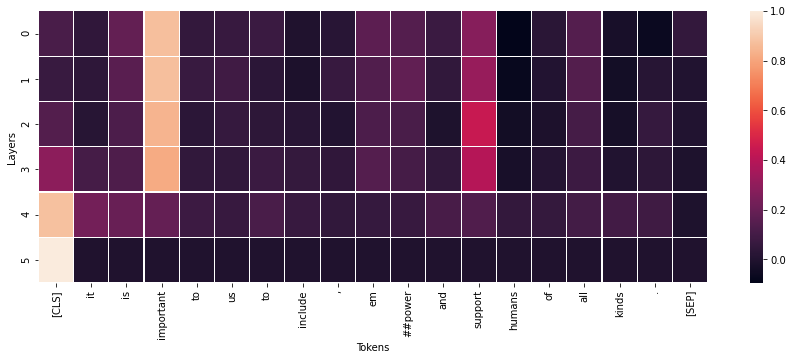

In [82]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(0,6))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Above chart shows how layerwise importance is given to each token in the input sentence

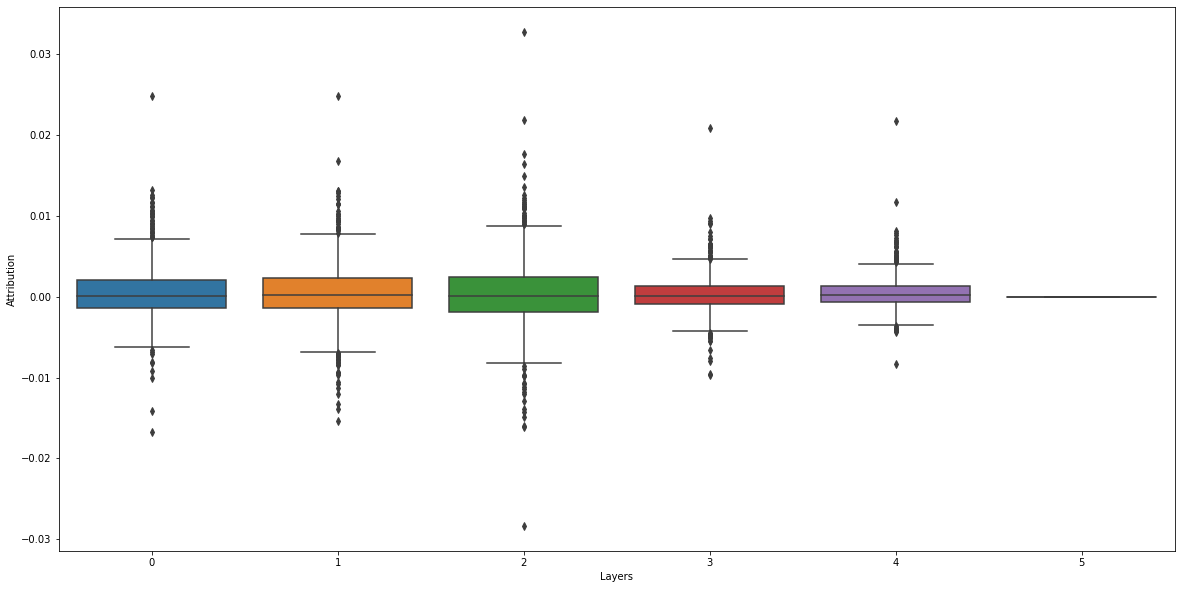

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

From above graph we can say that for token 2 (Which was selected earlier) layer 2 is having higher Attribution. The its slowing decreasing till the final layer. 

## Represent attributions as a probability density function (pdf):

In [83]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [84]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)

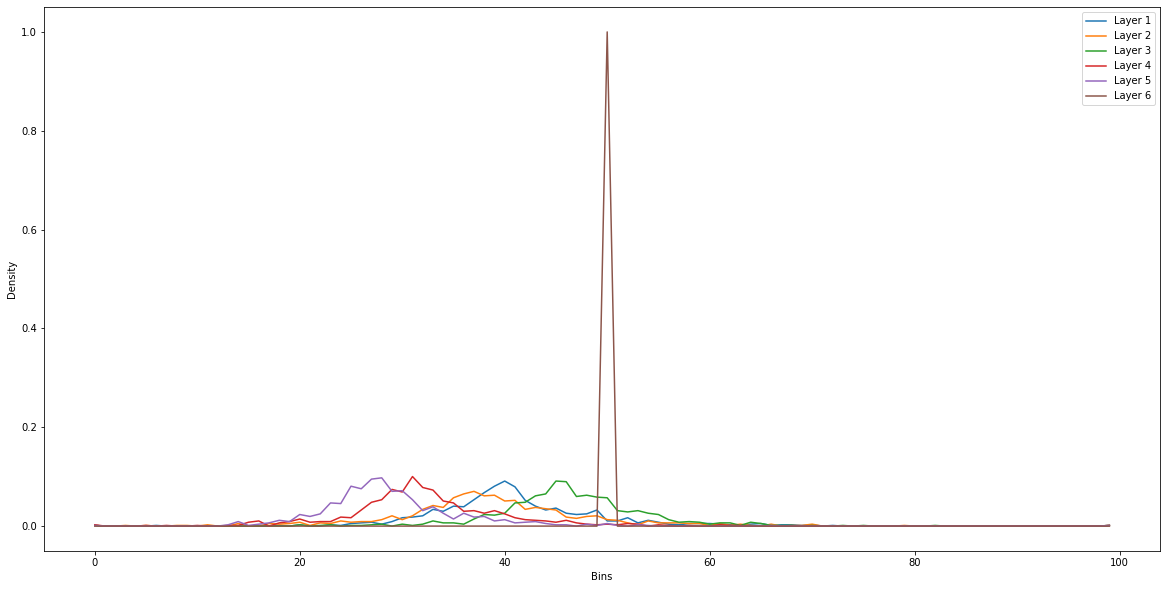

In [89]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,7)])
plt.show()

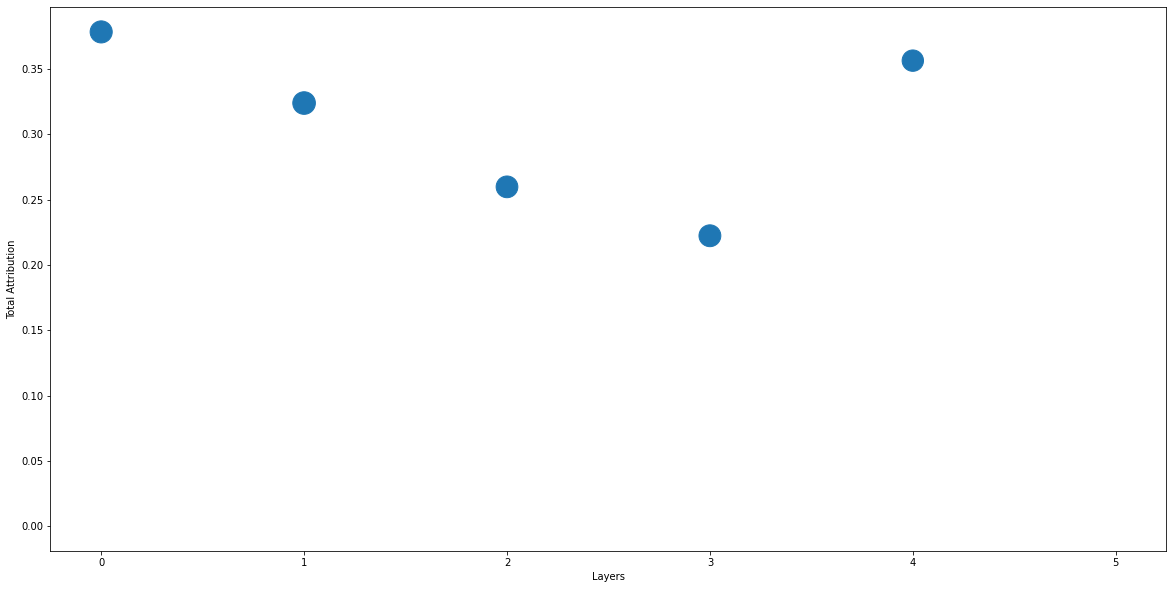

In [91]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(6), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()